In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interp
from itertools import cycle
from sklearn import svm, datasets, preprocessing
from sklearn.svm import SVC  
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, matthews_corrcoef, roc_curve, auc, make_scorer, roc_auc_score
from sklearn.utils import shuffle
import bisect
from scipy.stats import expon
from immas import classification

In [2]:
dataset_df1, dataset_df2 = classification.load_features_data('C:\\AIA-2018\\examples\\feature-tables\\train-data_1527086478.csv')

Number of images in the dataset 01: 205
Number of images in the dataset 02: 205
Number of regions in dataset 01: 3187
Number of regions in dataset 02: 3189


In [3]:
type(dataset_df2)

pandas.core.frame.DataFrame

In [6]:
# Loading of data and splitting in groups according to images
# Regions of the same image will stay in the same Pandas Dataframe in the end (dataset_df1 or dataset_df2)

# Load the dataset and groups by image filename
filename = 'C:\\AIA-2018\\examples\\feature-tables\\train-data_1527086478.csv'
data = pd.read_csv(filename)
data = data.drop(['Unnamed: 0'],axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data_per_imgfile = list(data.groupby('img_name'))
np.random.shuffle(data_per_imgfile)

# Splits in two datasets, for training and testing, with all regions associated to one image in the same set
data1 = []
data2 = []
i = 0
for name, group in data_per_imgfile:
    if i % 2 == 0:
        train = data[data['img_name']==name]
        data1.append(train)
    else:
        test = data[data['img_name']==name]
        data2.append(test)
    i += 1
dataset_df1 = pd.concat(data1)
dataset_df2 = pd.concat(data2)

In [3]:
# Converts from dataframe to numpy array
# Change here (or copy the code) if you want to select only some of the features to the array
# (only texture features, only geomatrical features...)

# Conversion from pandas dataframe to numpy array
# Keeps all the features from the original csv file
Feature = dataset_df1.drop(['class_id','img_name'], axis=1)
Target  = dataset_df1['class_id']
dataset01_data = Feature.as_matrix()
dataset01_labels = Target.as_matrix()

Feature = dataset_df2.drop(['class_id','img_name'], axis=1)
Target  = dataset_df2['class_id']
dataset02_data = Feature.as_matrix()
dataset02_labels = Target.as_matrix()

# Shuflles the datasets and creates one variable with labels for all the samples
dataset01_data, dataset01_labels = shuffle(dataset01_data, dataset01_labels, random_state=None)
dataset02_data, dataset02_labels = shuffle(dataset02_data, dataset02_labels, random_state=None)
all_data = np.vstack((dataset01_data, dataset02_data))
all_labels = np.concatenate((dataset01_labels, dataset02_labels),axis=0)

# Data standardization for each dataset (two methods)
dataset01_data = preprocessing.StandardScaler().fit_transform(dataset01_data)
dataset02_data = preprocessing.StandardScaler().fit_transform(dataset02_data)
all_data = preprocessing.StandardScaler().fit_transform(all_data)
#dataset01_data = preprocessing.robust_scale(dataset01_data)fit_transform
#dataset02_data = preprocessing.robust_scale(dataset02_data)

In [4]:
dataset01 = np.zeros((dataset01_data.shape[0],dataset01_data.shape[1]+1));
dataset01[:,:-1] = dataset01_data
dataset01[:,-1] = dataset01_labels

dataset02 = np.zeros((dataset02_data.shape[0],dataset02_data.shape[1]+1));
dataset02[:,:-1] = dataset02_data
dataset02[:,-1] = dataset02_labels

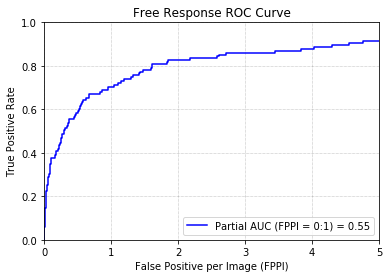

Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC curve for FPPI between 0 and 1: 0.54800


In [8]:
full_probabilities, full_auc, partial_auc, false_positive_rate, FROC_fpr, FROC_tpr = classification.run_SVM(dataset01, dataset02, kernel='poly', features='all_except_LBP')

In [4]:
# Trains and tests the classifier with both datasets (first considers the first dataset as the training set and the second as
# test, then inverts it)

# Classifier parameters

# For features without LBP - Maximizing AUC
#svclassifier = SVC(C=10, class_weight={1: 20}, gamma=0.0001, kernel='rbf', probability=True)
svclassifier = SVC(C=7, class_weight={1:15}, gamma=0.001, kernel='sigmoid', probability=True)
#svclassifier = SVC(C=0.001, class_weight={1:20}, kernel='linear', probability=True)
#svclassifier = SVC(C=0.5, class_weight={1: 10}, gamma=0.01, kernel='poly', degree=1, coef0=1.0, probability=True)

# For features without LBP - Maximizing Matthew Correlation Coefficient
#svclassifier = SVC(C=200, class_weight={1: 5}, gamma=0.001, kernel='rbf', probability=True)
#svclassifier = SVC(C=9, class_weight={1:5}, gamma=0.001, kernel='sigmoid', probability=True)
#svclassifier = SVC(C=0.01, class_weight={1:5}, kernel='linear', probability=True)
#svclassifier = SVC(C=10, class_weight={1: 5}, gamma=0.001, kernel='poly', degree=5, coef0=1.5, probability=True)

# For features + local LBP - Maximizing AUC
#svclassifier = SVC(C=0.01, class_weight={1: 10}, gamma=0.001, kernel='rbf', probability=True)
#svclassifier = SVC(C=0.1, class_weight={1:10}, gamma=0.0001, kernel='sigmoid', probability=True)
#svclassifier = SVC(C=0.001, class_weight='balanced', kernel='linear', probability=True)
#svclassifier = SVC(C=0.001, class_weight={1: 10}, gamma=0.001, kernel='poly', degree=3, coef0=0.5, probability=True)

# Trains classifier in DataSet01 and tests in DataSet02
svclassifier.fit(dataset01_data, dataset01_labels)
prob1 = svclassifier.predict_proba(dataset02_data)
prob1 = np.column_stack((prob1,dataset02_labels))

# Trains classifier in DataSet02 and tests in DataSet01
svclassifier.fit(dataset02_data, dataset02_labels)
prob2 = svclassifier.predict_proba(dataset01_data)
prob2 = np.column_stack((prob2,dataset01_labels))

# Calculate the probabilities taking both tests into account
full_prob = np.concatenate((prob1,prob2),axis=0)

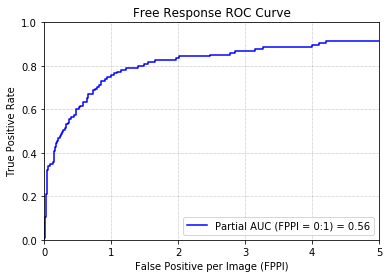

Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC curve for FPPI between 0 and 1: 0.56341


In [13]:
# FROC Curve section for the cross-validation test
false_positive_rate, true_positive_rate, thresholds = roc_curve(full_prob[:,-1], full_prob[:,1], pos_label=1, drop_intermediate=True)
roc_auc = auc(false_positive_rate, true_positive_rate)

# Counts to adjust the TPR and to create the False Positive per Image
unique, counts = np.unique(full_prob[:,-1], return_counts=True)
num_img = 410
num_pos_img = 115
regions = full_prob[:,-1].shape[0]
pos_reg = counts[1]
neg_reg = counts[0]
neg_reg_per_img = neg_reg / num_img
false_positive_rate = false_positive_rate * neg_reg_per_img
true_positive_rate = true_positive_rate * pos_reg / num_pos_img

# Calculates Partial AUC
partial_AUC = classification.partial_auc_score(false_positive_rate, true_positive_rate, 1)

# Plots the FROC Curve
plt.title('Free Response ROC Curve')
plt.plot(false_positive_rate, true_positive_rate, 'b',label='Partial AUC (FPPI = 0:1) = %0.2f'% partial_AUC)
plt.legend(loc='lower right')
plt.xlim([-0,5])
plt.ylim([-0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive per Image (FPPI)')
plt.grid(color='k', linestyle='dotted', linewidth=0.5, alpha=0.5)
plt.show()

print('Area under the original ROC curve for our classifier: %0.2f'% roc_auc)
print('Partial area under the FROC curve for FPPI between 0 and 1: %0.5f'% partial_AUC)

In [ ]:
# Extensive Grid Searches

# Scores for Grid Searches
calculate_MCC = make_scorer(matthews_corrcoef)
calculate_AUC = make_scorer(roc_auc_score)

# Grid Search parameters
parameters1 = {'C': [0.001, 0.01, 0.1, 0.5, 5, 7, 10, 20, 50, 200], 'gamma': [1e-4, 1e-3, 0.0003, 0.0005, 0.001, 0.01, 0.05, 0.1, 0.5], 'kernel': ['rbf'],
              'class_weight':['balanced', None, {1:1},{1:3},{1:5},{1:7},{1:9},{1:10},{1:15},{1:20},{1:25},{1:30},{1:50},{1:100}]}

parameters2 = {'C': [0.001, 0.01, 0.1, 0.5, 5, 7, 9, 10, 50, 200], 'gamma': [1e-4, 1e-3, 0.0005, 0.001, 0.005, 0.01, 0.03, 0.05, 0.1, 0.5], 'kernel': ['sigmoid'],
               'class_weight':['balanced', None, {1:1},{1:3},{1:5},{1:7},{1:9},{1:10},{1:15},{1:17},{1:20},{1:50},{1:100}]}

parameters3 = {'C': [0.0001, 0.0005, 0.001, 0.003, 0.005, 0.01, 0.1, 0.5, 5, 7, 8, 9, 10, 15, 20],'kernel': ['linear'],
               'class_weight':['balanced', None, {1:1},{1:3},{1:5},{1:7},{1:9},{1:10},{1:15},{1:20},{1:22},{1:24},{1:30},{1:40},{1:50},{1:100}]}

parameters4 = {'C': [0.01, 0.1, 0.3, 0.5, 1, 7, 10, 100], 'gamma': [1e-3, 0.01, 0.05, 0.1], 'kernel': ['poly'],
               'class_weight':['balanced',{1:5},{1:10},{1:50}],'degree':[1,3,5], 'coef0':[0.0, 0.5, 1.0, 1.5]}

gridSVM = svm.SVC()
grid_search1 = GridSearchCV(gridSVM, param_grid=parameters1, scoring=calculate_MCC, refit=True, verbose=1, return_train_score=False)
grid_search1.fit(all_data, all_labels)

grid_search2 = GridSearchCV(gridSVM, param_grid=parameters2, scoring=calculate_MCC, refit=True, verbose=1, return_train_score=False)
grid_search2.fit(all_data, all_labels)

grid_search3 = GridSearchCV(gridSVM, param_grid=parameters3, scoring=calculate_MCC, refit=True, verbose=1, return_train_score=False)
grid_search3.fit(all_data, all_labels)

grid_search4 = GridSearchCV(gridSVM, param_grid=parameters4, scoring=calculate_MCC, refit=True, verbose=1, return_train_score=False)
grid_search4.fit(all_data, all_labels)

In [ ]:
# Results for extensive Grid Searches
print(grid_search1.best_score_, grid_search1.best_params_)
print(grid_search2.best_score_, grid_search2.best_params_)
print(grid_search3.best_score_, grid_search3.best_params_)
print(grid_search4.best_score_, grid_search4.best_params_)

In [ ]:
# Randomized Grid Searches

# Scores for Grid Searches
calculate_MCC = make_scorer(matthews_corrcoef)
calculate_AUC = make_scorer(roc_auc_score)

# Grid Search parameters
parameters1 = {'C': expon(scale=100), 'gamma': expon(scale=.1), 'kernel': ['rbf'],
              'class_weight':['balanced', None, {1:1},{1:3},{1:5},{1:7},{1:9},{1:10},{1:15},{1:20},{1:25},{1:30},{1:40},{1:50},{1:100},{1:150},{1:200}]}

parameters2 = {'C': expon(scale=100), 'gamma': expon(scale=.1), 'kernel': ['sigmoid'],
              'class_weight':['balanced', None, {1:1},{1:3},{1:5},{1:7},{1:9},{1:10},{1:15},{1:20},{1:25},{1:30},{1:40},{1:50},{1:100},{1:150},{1:200}]}

parameters3 = {'C': expon(scale=100),'kernel': ['linear'],
               'class_weight':['balanced', None, {1:1},{1:3},{1:5},{1:7},{1:9},{1:10},{1:15},{1:20},{1:25},{1:30},{1:50},{1:100}]}

parameters4 = {'C': expon(scale=100), 'gamma': expon(scale=.1), 'kernel': ['poly'],
               'class_weight':['balanced', None, {1:1},{1:3},{1:5},{1:7},{1:9},{1:10},{1:15},{1:20},{1:25},{1:30},{1:40},{1:50},{1:100},{1:150},{1:200}],'degree':[1,2,3], 'coef0':[1.0, 2.0]}

gridSVM = svm.SVC()
grid_search1_rand = RandomizedSearchCV(gridSVM, param_distributions=parameters1, n_iter=10, scoring='roc_auc', refit=True, verbose=1,return_train_score=False)
grid_search1_rand.fit(all_data, all_labels)

grid_search2_rand = RandomizedSearchCV(gridSVM, param_distributions=parameters2, n_iter=10, scoring='roc_auc', refit=True, verbose=1, return_train_score=False)
grid_search2_rand.fit(all_data, all_labels)

grid_search3_rand = RandomizedSearchCV(gridSVM, param_distributions=parameters3, n_iter=5, scoring='roc_auc', refit=True, verbose=1, return_train_score=False)
grid_search3_rand.fit(all_data, all_labels)

grid_search4_rand = RandomizedSearchCV(gridSVM, param_distributions=parameters4, n_iter=5, scoring='roc_auc', refit=True, verbose=1, return_train_score=False)
grid_search4_rand.fit(all_data, all_labels)

In [ ]:
# Results for Randomized Grid Searches
print(grid_search1_rand.best_score_, grid_search1_rand.best_params_)
print(grid_search2_rand.best_score_, grid_search2_rand.best_params_)
print(grid_search3_rand.best_score_, grid_search3_rand.best_params_)
print(grid_search4_rand.best_score_, grid_search4_rand.best_params_)

In [ ]:
# Extensive Grid Searches for LBP (less parameters)

# Scores for Grid Searches
calculate_MCC = make_scorer(matthews_corrcoef)
calculate_AUC = make_scorer(roc_auc_score)

# Grid Search parameters
parameters1 = {'C': [0.001, 0.01, 0.1, 0.5, 10, 100], 'gamma': [1e-4, 1e-3, 0.001, 0.01, 0.1], 'kernel': ['rbf'],
              'class_weight':['balanced', {1:5},{1:10},{1:50}]}

parameters2 = {'C': [0.001, 0.01, 0.1, 0.5, 10, 100], 'gamma': [1e-4, 1e-3, 0.001, 0.01, 0.1], 'kernel': ['sigmoid'],
               'class_weight':['balanced', {1:5},{1:10},{1:30},{1:50}]}

parameters3 = {'C': [0.001, 0.01, 0.1, 0.5, 10, 100],'kernel': ['linear'],
               'class_weight':['balanced', None, {1:1},{1:5},{1:7},{1:10},{1:15},{1:20},{1:30},{1:100}]}

parameters4 = {'C': [0.001, 0.01, 0.1, 0.5, 10], 'gamma': [1e-3, 0.01, 0.1], 'kernel': ['poly'],
               'class_weight':['balanced',{1:5},{1:10},{1:50}],'degree':[1,3,5], 'coef0':[0.0, 0.5, 1.0]}

gridSVM = svm.SVC()
grid_search1_lbp = GridSearchCV(gridSVM, param_grid=parameters1, scoring='roc_auc', refit=True, n_jobs=2, pre_dispatch='2*n_jobs', cv=2, verbose=2, return_train_score=False)
grid_search1_lbp.fit(all_data, all_labels)

grid_search2_lbp = GridSearchCV(gridSVM, param_grid=parameters2, scoring='roc_auc', refit=True, n_jobs=2, pre_dispatch='2*n_jobs', cv=2, verbose=3, return_train_score=False)
grid_search2_lbp.fit(all_data, all_labels)

grid_search3_lbp = GridSearchCV(gridSVM, param_grid=parameters3, scoring='roc_auc', refit=True, n_jobs=2, pre_dispatch='2*n_jobs', cv=2, verbose=3, return_train_score=False)
grid_search3_lbp.fit(all_data, all_labels)

grid_search4_lbp = GridSearchCV(gridSVM, param_grid=parameters4, scoring='roc_auc', refit=True, n_jobs=2, pre_dispatch='2*n_jobs', cv=2, verbose=3, return_train_score=False)
grid_search4_lbp.fit(all_data, all_labels)

In [ ]:
# Results for extensive Grid Searches
print(grid_search1_lbp.best_score_, grid_search1_lbp.best_params_)
print(grid_search2_lbp.best_score_, grid_search2_lbp.best_params_)
print(grid_search3_lbp.best_score_, grid_search3_lbp.best_params_)
print(grid_search4_lbp.best_score_, grid_search4_lbp.best_params_)